In [1]:
import torch
import torch.nn as nn
import timm
from torch.utils.data import DataLoader
import os
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torch import nn, optim
from torch.nn import functional as F
from torchvision import models
import sys
from tqdm import tqdm
import time
import copy
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from PIL import Image
import torch.cuda.amp as amp
import functools
import types
import seaborn as sns
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [5]:
batch_size = 64

# DATA

In [6]:
dataset_path = "D:\\ASD_FACE"

In [7]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            #T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train\\"), transform = transform)
        train_data = remap_class_labels(train_data)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid\\"), transform=transform)
        val_data = remap_class_labels(val_data)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test\\"), transform=transform)
        test_data = remap_class_labels(test_data)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
        return val_loader, test_loader, len(val_data), len(test_data)

def remap_class_labels(dataset):     # Remap class labels to ensure 0: Non_Autistic, 1: Autistic
        corrected_class_to_idx = {'non_autistic': 0, 'autistic': 1}
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
        dataset.samples = [(path, corrected_class_to_idx[idx_to_class[cls]]) for path, cls in dataset.samples]
        dataset.class_to_idx = corrected_class_to_idx  # Update to corrected mapping
        return dataset

In [8]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, batch_size, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, batch_size, train=False)

In [9]:
print(f"Class indices: {train_loader.dataset.class_to_idx}")

Class indices: {'non_autistic': 0, 'autistic': 1}


In [10]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [11]:
img_batch, label_batch = next(iter(train_loader))
print(img_batch.shape)
print(label_batch)

torch.Size([64, 3, 224, 224])
tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0])


In [12]:
def plot_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array(timm.data.IMAGENET_DEFAULT_STD) + np.array(timm.data.IMAGENET_DEFAULT_MEAN) 
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        
        label_index = labels[i].item() 
        plt.title(f'Label: {label_index}, ({class_names[label_index]}) ') 
        plt.axis('off')
    plt.show()

In [13]:
class_names = {0: 'non_autistic', 1: 'autistic'}

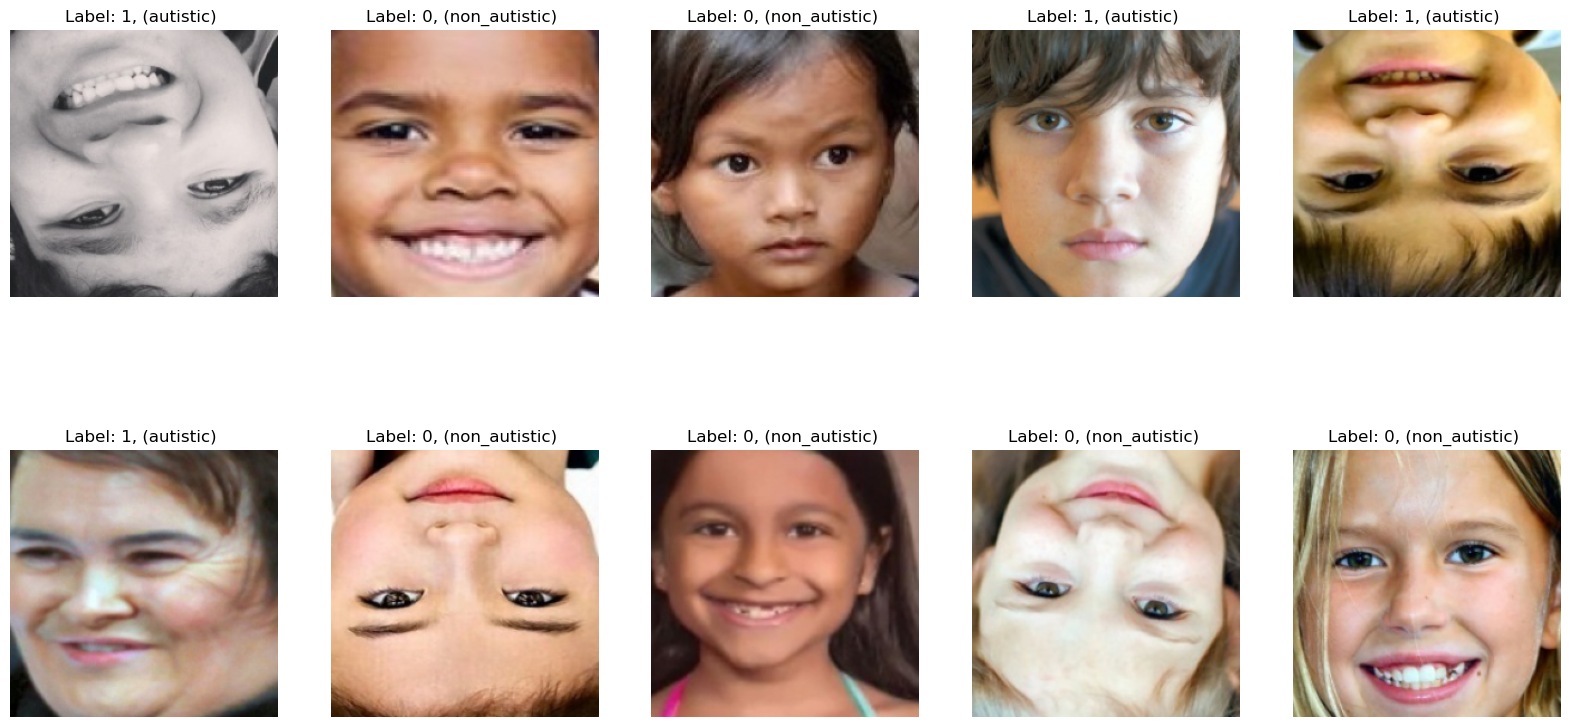

In [14]:
plot_sample_images(img_batch, label_batch, class_names, num_images=10)

# Model

In [15]:
class SwinModel(nn.Module):
    def __init__(self, backbone = 'swin_base_patch4_window7_224', dropout_prob=0.5):
        super(SwinModel, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(self.backbone.num_features, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.backbone(x)
        x = x.flatten(1)
        x = self.pool(x.unsqueeze(-1)).squeeze(-1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

    def extract_attention_layers(self):
        attn_layers = []
        for name, module in self.backbone.named_modules():
            if 'attn' in name and isinstance(module, nn.Module) and not any(sub in name for sub in ['qkv', 'proj', 'attn_drop', 'softmax']):
                attn_layers.append((name, module))
        return attn_layers
    
    def attention_forward(self, attn_maps):
        def forward_with_attn_map(self, x, *args, **kwargs):
            B, N, C = x.shape
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)  

            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            tensor_attn = attn[0, 0, :, :].detach()
            attn_maps.append(tensor_attn.cpu().numpy())
            #print(f"attention map shape: {tensor_attn.shape}")

            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
            x = self.proj(x)
            x = self.proj_drop(x)
            return x

        attn_layers = self.extract_attention_layers()
        for name, attn_layer in attn_layers:
            forward_fn = functools.partial(forward_with_attn_map, attn_maps=attn_maps)
            attn_layer.forward = types.MethodType(forward_fn, attn_layer)
            #print(f"forward method for layer: {name}")

In [16]:
model = SwinModel().to(device)

# TRAIN

In [17]:
import copy
def train_and_eval_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print("-" * 10)
        
        for phase in ['train', 'val']:  
            if phase == 'train':
                model.train()  
            else:
                model.eval()  
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1) 
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)
                    preds = torch.round(outputs)  
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                 scheduler.step() 
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 
                epochs_no_improve = 0
            elif phase == 'val':
                epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"Best Val Acc: {best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [18]:
criterion = nn.BCELoss()
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [19]:
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_and_eval_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=40)

Epoch 1/40
----------


100%|██████████| 40/40 [34:08<00:00, 51.22s/it]  


train Loss: 0.6202 Acc: 0.6475


100%|██████████| 2/2 [00:40<00:00, 20.28s/it]


val Loss: 0.4842 Acc: 0.7700

Epoch 2/40
----------


100%|██████████| 40/40 [15:34<00:00, 23.36s/it]


train Loss: 0.4582 Acc: 0.7902


100%|██████████| 2/2 [00:17<00:00,  8.96s/it]


val Loss: 0.4144 Acc: 0.8100

Epoch 3/40
----------


100%|██████████| 40/40 [15:34<00:00, 23.37s/it]


train Loss: 0.3833 Acc: 0.8281


100%|██████████| 2/2 [00:19<00:00,  9.86s/it]


val Loss: 0.3504 Acc: 0.8500

Epoch 4/40
----------


100%|██████████| 40/40 [15:30<00:00, 23.26s/it]


train Loss: 0.3469 Acc: 0.8502


100%|██████████| 2/2 [00:17<00:00,  8.55s/it]


val Loss: 0.3339 Acc: 0.8400

Epoch 5/40
----------


100%|██████████| 40/40 [15:29<00:00, 23.24s/it]


train Loss: 0.2992 Acc: 0.8734


100%|██████████| 2/2 [00:17<00:00,  8.60s/it]


val Loss: 0.3387 Acc: 0.8500

Epoch 6/40
----------


100%|██████████| 40/40 [19:13<00:00, 28.83s/it]


train Loss: 0.2587 Acc: 0.8892


100%|██████████| 2/2 [00:45<00:00, 22.53s/it]


val Loss: 0.3179 Acc: 0.8600

Epoch 7/40
----------


100%|██████████| 40/40 [32:26<00:00, 48.67s/it]


train Loss: 0.2557 Acc: 0.8963


100%|██████████| 2/2 [00:48<00:00, 24.21s/it]


val Loss: 0.3602 Acc: 0.8200

Epoch 8/40
----------


100%|██████████| 40/40 [32:27<00:00, 48.68s/it]


train Loss: 0.2310 Acc: 0.9046


100%|██████████| 2/2 [00:47<00:00, 23.72s/it]


val Loss: 0.3410 Acc: 0.8600

Epoch 9/40
----------


100%|██████████| 40/40 [15:40<00:00, 23.52s/it]


train Loss: 0.2270 Acc: 0.9093


100%|██████████| 2/2 [00:18<00:00,  9.35s/it]


val Loss: 0.3105 Acc: 0.8700

Epoch 10/40
----------


100%|██████████| 40/40 [15:31<00:00, 23.28s/it]


train Loss: 0.2052 Acc: 0.9168


100%|██████████| 2/2 [00:17<00:00,  8.68s/it]


val Loss: 0.3180 Acc: 0.8500

Epoch 11/40
----------


100%|██████████| 40/40 [15:30<00:00, 23.26s/it]


train Loss: 0.1863 Acc: 0.9286


100%|██████████| 2/2 [00:17<00:00,  8.67s/it]


val Loss: 0.3235 Acc: 0.8200

Epoch 12/40
----------


100%|██████████| 40/40 [15:30<00:00, 23.27s/it]


train Loss: 0.1865 Acc: 0.9259


100%|██████████| 2/2 [00:17<00:00,  8.64s/it]


val Loss: 0.3154 Acc: 0.8800

Epoch 13/40
----------


100%|██████████| 40/40 [15:14<00:00, 22.87s/it]


train Loss: 0.1817 Acc: 0.9259


100%|██████████| 2/2 [00:18<00:00,  9.37s/it]


val Loss: 0.3507 Acc: 0.8400

Epoch 14/40
----------


100%|██████████| 40/40 [19:19<00:00, 28.99s/it]


train Loss: 0.1753 Acc: 0.9357


100%|██████████| 2/2 [00:47<00:00, 23.64s/it]


val Loss: 0.3525 Acc: 0.8400

Epoch 15/40
----------


100%|██████████| 40/40 [32:31<00:00, 48.79s/it]


train Loss: 0.1639 Acc: 0.9357


100%|██████████| 2/2 [00:45<00:00, 22.55s/it]


val Loss: 0.3226 Acc: 0.8300

Epoch 16/40
----------


100%|██████████| 40/40 [15:16<00:00, 22.90s/it]


train Loss: 0.1417 Acc: 0.9531


100%|██████████| 2/2 [00:18<00:00,  9.39s/it]


val Loss: 0.3167 Acc: 0.8600

Epoch 17/40
----------


100%|██████████| 40/40 [15:16<00:00, 22.91s/it]


train Loss: 0.1467 Acc: 0.9468


100%|██████████| 2/2 [00:18<00:00,  9.49s/it]


val Loss: 0.3227 Acc: 0.8500
Early stopping triggered after 17 epochs
Training complete in 348m 12s
Best Val Acc: 0.8800


In [20]:
def plot_metrics(epochs, train_accuracies, val_accuracies, train_losses, val_losses): 

    epochs = convert_to_numpy(epochs)
    train_accuracies = convert_to_numpy(train_accuracies)
    val_accuracies = convert_to_numpy(val_accuracies)
    train_losses = convert_to_numpy(train_losses)
    val_losses = convert_to_numpy(val_losses)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def convert_to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    elif isinstance(data, range):
        return np.array(list(data))
    elif isinstance(data, list):
        return np.array([convert_to_numpy(d) for d in data])
    return data

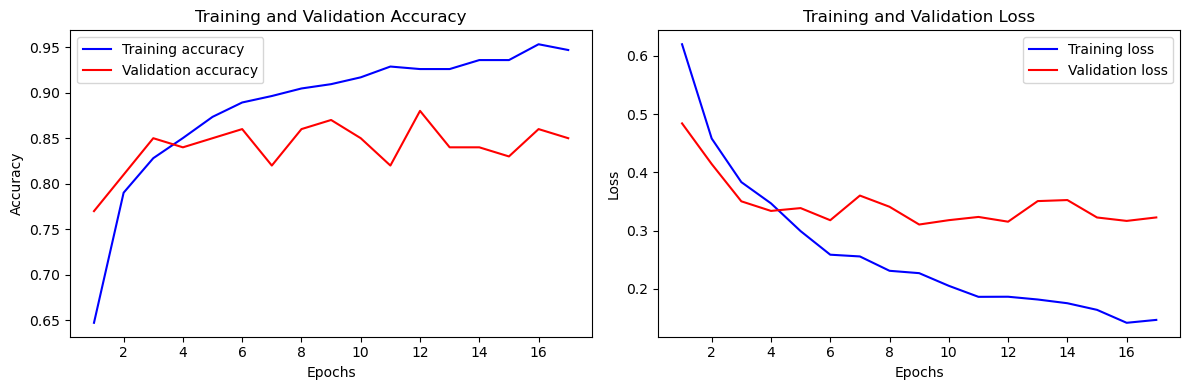

In [21]:
epochs = 17
plot_metrics(range(1, epochs + 1), train_accuracies, val_accuracies, train_losses, val_losses)

# Test

In [22]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model, dataloaders, dataset_size, criterion):
    model = model.to(device)
    model.eval() 

    running_loss = 0.0
    running_corrects = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)


    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return all_preds, all_labels

In [23]:
dataloaders['test'] = test_loader
all_preds, all_labels = test_model(trained_model, dataloaders, test_data_len, criterion)

100%|██████████| 5/5 [00:49<00:00,  9.88s/it]

Test Loss: 0.2832 Acc: 0.9000
Precision: 0.8750
Recall: 0.9333
F1 Score: 0.9032
